# Report P2- COMPUTER VISION SUPERESTRELLAS

En nuestro análisis, las dos últimas imágenes fueron las más sencillas de interpretar porque respondieron bien desde el principio al uso de saliency maps estándar. Con este método pudimos obtener mapas de relevancia claros y suficientemente estables para identificar qué regiones activaban al modelo y de qué manera influían en su predicción. No fue necesario aplicar técnicas adicionales de suavizado ni ajustes más complejos: comparabamos la clase predicha con la clase objetivo para averiguar que píxeles podían reducir la predicción de la clase predicha aumentando la predicción de la clase objetivo. Esto lo conseguíamos restando uno del otro, obteniendo los píxeles positivos como los que más llevarían la imagen de la predicción a la clase real. 

Para la segunda y la tercera imagen, en cambio, el gradiente directo no era tan informativo. El mapa resultaba en negro, indicando vanishing gradients, lo cual que difícil interpretar qué zonas eran realmente relevantes. En estos casos recurrimos a SmoothGrad, generando múltiples muestras a partir de la imagen original con ruido añadido y promediando los gradientes. Este proceso suavizó la señal y reveló patrones más consistentes, permitiendo obtener mapas de saliencia mucho más útiles. Gracias a SmoothGrad pudimos identificar con claridad las áreas que contribuían a la decisión del modelo, algo que no era posible con el método básico. Con estos mapas repetimos la diferencia entre el objetivo y la real, consiguiendo así resultados correctos

La primera imagen fue el caso más complejo de todo el conjunto. Ni los saliency maps directos ni SmoothGrad ofrecían un resultado utilizable. Tras varios intentos, concluimos que el modelo no estaba proporcionando gradientes suficientemente diferenciados como para extraer información interpretable con los métodos habituales. Por ello, se implementó un método estocástico que intenta corregir la predicción del modelo modificando por fuerza bruta hasta el 40% de los píxeles de una imagen. Cada iteración genera una perturbación aleatoria y se evalúa el modelo y si tras 10 000 intentos no mejora, se reinicia el proceso con la imagen original. El bucle termina solo cuando la predicción coincide con la etiqueta correcta.

In [1]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from captum.attr import Saliency

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Device: cuda


C:\Users\javir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [4]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

In [5]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False)
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

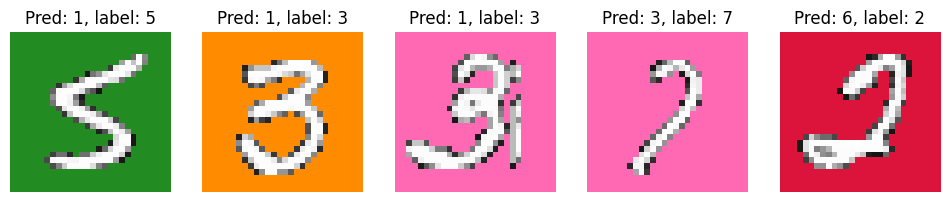

In [8]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
plt.show()

In [9]:
# Create edited directory
edited_dir = challenge_dir / 'final'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()
    
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')

    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')

Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 38.90%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 29.97%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 31.76%
Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 36.48%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 14.92%


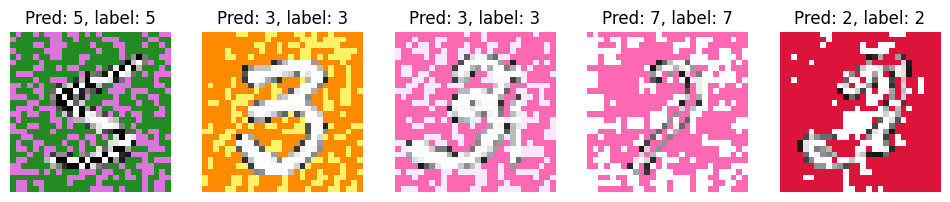

In [10]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/data/MNIST/challenge/final')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
plt.show()